# 03 — GDELT Geopolitical Event Pipeline

Objective:
Download, cache, aggregate and score GDELT/other news-event records for each chokepoint (2019–2025). Produce a daily, chokepoint-level geopolitical risk time series suitable for fusion with traffic and weather.

In [1]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "gen-lang-client-0176791892-0793226caa00.json"
print("Environment variable set.")

Environment variable set.


In [2]:
# Import necessary libraries
import os
import pandas as pd
from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client()

print("BigQuery client initialized successfully.")

BigQuery client initialized successfully.


In [3]:
processed_data_dir = 'processed_data'
metadata_file_path = os.path.join(processed_data_dir, 'chokepoint_definitions.csv')

chokepoint_metadata = pd.read_csv(metadata_file_path)
chokepoint_metadata['chokepoint_id'] = chokepoint_metadata['chokepoint_id'].astype(str)
print("Successfully loaded chokepoint definitions.")
display(chokepoint_metadata)

Successfully loaded chokepoint definitions.


,chokepoint_id,chokepoint_name,lat,lon
0,cp_bab_el_mandeb,Bab el-Mandeb Strait,12.788597,43.349545
1,cp_bosporus,Bosporus Strait,41.169282,29.091501
2,cp_malacca,Malacca Strait,1.516955,102.665106
3,cp_panama,Panama Canal,9.120512,-79.767238
4,cp_suez,Suez Canal,30.593346,32.436882


In [16]:
df_traffic = pd.read_csv('processed_ais_data/chokepoints_daily_data_2025_10_14.csv')

df_traffic['date'] = pd.to_datetime(df_traffic['date'])

project_start_date = df_traffic['date'].min()
project_end_date = df_traffic['date'].max()

In [ ]:
import os
import hashlib
import pandas as pd
from google.cloud import bigquery
from pathlib import Path

# CONFIGURATION 
# GCP credential file paths
CREDENTIAL_FILES = [
    "deft-strata-475218-s0-73057339d8b6.json",
    "demo1-475218-a9dc4306bad6.json",
    "melodic-crane-475218-i7-46e56fbaba53.json",
    "tribal-contact-475218-i1-92a2948b4521.json",
    "vibrant-map-475218-i5-b6cd1a28aef2.json",
    "voltaic-racer-475219-k8-1f9dc45b66f5.json"
]

CACHE_DIR = Path("gdelt_cache")
CACHE_DIR.mkdir(exist_ok=True)

current_account_idx = 0
client = bigquery.Client.from_service_account_json(CREDENTIAL_FILES[current_account_idx])

def switch_account():
    """Switch to next available account."""
    global current_account_idx, client
    current_account_idx += 1
    
    if current_account_idx >= len(CREDENTIAL_FILES):
        raise Exception("All accounts have exceeded quota!")
    
    print(f"\n  Switching to account {current_account_idx + 1}/{len(CREDENTIAL_FILES)}")
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = CREDENTIAL_FILES[current_account_idx]
    client = bigquery.Client.from_service_account_json(CREDENTIAL_FILES[current_account_idx])

def get_cache_path(chokepoint_name, lat, lon, radius_km, start_date, end_date):
    """Generate cache file path."""
    params = f"{chokepoint_name}_{lat}_{lon}_{radius_km}_{start_date}_{end_date}"
    cache_key = hashlib.md5(params.encode()).hexdigest()
    return CACHE_DIR / f"{cache_key}.parquet"

def fetch_gdelt_events(chokepoint_name, lat, lon, radius_km, start_date, end_date):
    """
    Queries the GDELT database for specific event types around a location.
    Uses caching and automatic account switching.

    Returns:
        A pandas DataFrame with the events found.
    """
    # Check cache first
    cache_path = get_cache_path(chokepoint_name, lat, lon, radius_km, start_date, end_date)
    if cache_path.exists():
        print(f"  ✓ Loading from cache for {chokepoint_name} {start_date}-{end_date}")
        return pd.read_parquet(cache_path)
    
    print(f"  Querying events for {chokepoint_name} from {start_date} to {end_date}...")
    
    radius_meters = radius_km * 1000
    relevant_event_codes = "'18', '19', '20', '138', '128'"

    query = f"""
        SELECT
            SQLDATE,
            Actor1Geo_Lat,
            Actor1Geo_Long,
            EventCode,
            GoldsteinScale
        FROM
            `gdelt-bq.gdeltv2.events`
        WHERE
            SQLDATE >= {start_date} AND SQLDATE <= {end_date}
            AND
            ST_DWithin(
                ST_GeogPoint(Actor1Geo_Long, Actor1Geo_Lat),
                ST_GeogPoint({lon}, {lat}),
                {radius_meters}
            )
            AND
            EventRootCode IN ({relevant_event_codes})
    """
    
    max_retries = len(CREDENTIAL_FILES)
    
    for attempt in range(max_retries):
        try:
            query_job = client.query(query)
            results_df = query_job.to_dataframe()
            
            # Save to cache
            if not results_df.empty:
                results_df.to_parquet(cache_path, index=False)
                print(f"  ✓ Saved to cache")
            
            return results_df
            
        except Exception as e:
            error_msg = str(e)
            
            if "quota" in error_msg.lower() or "403" in error_msg:
                print(f"  Quota exceeded on account {current_account_idx + 1}")
                
                if attempt < max_retries - 1:
                    switch_account()
                    continue
                else:
                    print(f"  ❌ All accounts exhausted!")
                    return pd.DataFrame()
            else:
                print(f"  ❌ Error: {e}")
                return pd.DataFrame()
    
    return pd.DataFrame()

all_events_df = []
years = ["2019", "2020", "2021", "2022", "2023", "2024", "2025"]

radii = {
    'cp_suez': 250, 'cp_bab_el_mandeb': 300, 
    'cp_malacca': 250, 'cp_panama': 200, 'cp_bosporus': 250
}

print(f"Targeting {len(years)} years of geopolitical data ({years[0]}-{years[-1]}) to match traffic data.")
print(f"Using {len(CREDENTIAL_FILES)} accounts with cache directory: {CACHE_DIR.absolute()}\n")

for index, row in chokepoint_metadata.iterrows():
    cp_id, cp_name = row['chokepoint_id'], row['chokepoint_name']
    print(f"\nProcessing {cp_name} ({cp_id})...")
    
    for year in years:
        start_date, end_date = f"{year}0101", f"{year}1231"
        
        yearly_events = fetch_gdelt_events(
            chokepoint_name=cp_name, 
            lat=row['lat'], 
            lon=row['lon'],
            radius_km=radii.get(cp_id, 200),
            start_date=start_date, 
            end_date=end_date
        )
        
        if not yearly_events.empty:
            yearly_events['chokepoint_id'] = cp_id
            all_events_df.append(yearly_events)
            print(f"  -> Found {len(yearly_events)} relevant events for {year}.")
        else:
            print(f"  -> No relevant events found for {year}.")

# Combine all results
if all_events_df:
    final_df = pd.concat(all_events_df, ignore_index=True)
    print(f"\n✓ Total events collected: {len(final_df)}")
else:
    final_df = pd.DataFrame()

Targeting 7 years of geopolitical data (2019-2025) to match traffic data.
Using 6 accounts with cache directory: /maritime analysis/gdelt_cache


Processing Bab el-Mandeb Strait (cp_bab_el_mandeb)...
  Querying events for Bab el-Mandeb Strait from 20190101 to 20191231...


  ✓ Saved to cache
  -> Found 17857 relevant events for 2019.
  Querying events for Bab el-Mandeb Strait from 20200101 to 20201231...


  ✓ Saved to cache
  -> Found 9983 relevant events for 2020.
  Querying events for Bab el-Mandeb Strait from 20210101 to 20211231...


  ✓ Saved to cache
  -> Found 9562 relevant events for 2021.
  Querying events for Bab el-Mandeb Strait from 20220101 to 20221231...


  ✓ Saved to cache
  -> Found 6857 relevant events for 2022.
  Querying events for Bab el-Mandeb Strait from 20230101 to 20231231...


  ✓ Saved to cache
  -> Found 6969 relevant events for 2023.
  Querying events for Bab el-Mandeb Strait from 20240101 to 20241231...


  ✓ Saved to cache
  -> Found 14746 relevant events for 2024.
  Querying events for Bab el-Mandeb Strait from 20250101 to 20251231...


  ✓ Saved to cache
  -> Found 10756 relevant events for 2025.

Processing Bosporus Strait (cp_bosporus)...
  Querying events for Bosporus Strait from 20190101 to 20191231...


  ✓ Saved to cache
  -> Found 19780 relevant events for 2019.
  Querying events for Bosporus Strait from 20200101 to 20201231...


  ✓ Saved to cache
  -> Found 14432 relevant events for 2020.
  Querying events for Bosporus Strait from 20210101 to 20211231...


  ✓ Saved to cache
  -> Found 10901 relevant events for 2021.
  Querying events for Bosporus Strait from 20220101 to 20221231...


  ✓ Saved to cache
  -> Found 12895 relevant events for 2022.
  Querying events for Bosporus Strait from 20230101 to 20231231...


  ✓ Saved to cache
  -> Found 12655 relevant events for 2023.
  Querying events for Bosporus Strait from 20240101 to 20241231...


  ✓ Saved to cache
  -> Found 12521 relevant events for 2024.
  Querying events for Bosporus Strait from 20250101 to 20251231...


  ✓ Saved to cache
  -> Found 9691 relevant events for 2025.

Processing Malacca Strait (cp_malacca)...
  Querying events for Malacca Strait from 20190101 to 20191231...


  ✓ Saved to cache
  -> Found 12553 relevant events for 2019.
  Querying events for Malacca Strait from 20200101 to 20201231...


  ✓ Saved to cache
  -> Found 9718 relevant events for 2020.
  Querying events for Malacca Strait from 20210101 to 20211231...


  ✓ Saved to cache
  -> Found 7690 relevant events for 2021.
  Querying events for Malacca Strait from 20220101 to 20221231...


  ✓ Saved to cache
  -> Found 5526 relevant events for 2022.
  Querying events for Malacca Strait from 20230101 to 20231231...


  ✓ Saved to cache
  -> Found 6637 relevant events for 2023.
  Querying events for Malacca Strait from 20240101 to 20241231...


  ✓ Saved to cache
  -> Found 7502 relevant events for 2024.
  Querying events for Malacca Strait from 20250101 to 20251231...


  ✓ Saved to cache
  -> Found 4949 relevant events for 2025.

Processing Panama Canal (cp_panama)...
  Querying events for Panama Canal from 20190101 to 20191231...


  ✓ Saved to cache
  -> Found 3736 relevant events for 2019.
  Querying events for Panama Canal from 20200101 to 20201231...


  ✓ Saved to cache
  -> Found 2529 relevant events for 2020.
  Querying events for Panama Canal from 20210101 to 20211231...


  ✓ Saved to cache
  -> Found 2297 relevant events for 2021.
  Querying events for Panama Canal from 20220101 to 20221231...


  ✓ Saved to cache
  -> Found 2140 relevant events for 2022.
  Querying events for Panama Canal from 20230101 to 20231231...


  ✓ Saved to cache
  -> Found 2675 relevant events for 2023.
  Querying events for Panama Canal from 20240101 to 20241231...


  ✓ Saved to cache
  -> Found 2593 relevant events for 2024.
  Querying events for Panama Canal from 20250101 to 20251231...


  ✓ Saved to cache
  -> Found 2506 relevant events for 2025.

Processing Suez Canal (cp_suez)...
  Querying events for Suez Canal from 20190101 to 20191231...


  ✓ Saved to cache
  -> Found 153402 relevant events for 2019.
  Querying events for Suez Canal from 20200101 to 20201231...


  ✓ Saved to cache
  -> Found 82036 relevant events for 2020.
  Querying events for Suez Canal from 20210101 to 20211231...


  ✓ Saved to cache
  -> Found 126784 relevant events for 2021.
  Querying events for Suez Canal from 20220101 to 20221231...


  ✓ Saved to cache
  -> Found 105556 relevant events for 2022.
  Querying events for Suez Canal from 20230101 to 20231231...
  ⚠️  Quota exceeded on account 1

⚠️  Switching to account 2/6


  ✓ Saved to cache
  -> Found 440447 relevant events for 2023.
  Querying events for Suez Canal from 20240101 to 20241231...


  ✓ Saved to cache
  -> Found 669592 relevant events for 2024.
  Querying events for Suez Canal from 20250101 to 20251231...


  ✓ Saved to cache
  -> Found 302001 relevant events for 2025.

✓ Total events collected: 2122474


In [ ]:
def load_all_cached_data():
    """
    Load all parquet files from cache directory.
    """
    cache_files = list(CACHE_DIR.glob("*.parquet"))
    
    print(f"\n Found {len(cache_files)} cached files")
    print("Loading all cached data...")
    
    all_cached_dfs = []
    for cache_file in cache_files:
        df = pd.read_parquet(cache_file)
        all_cached_dfs.append(df)
        print(f"  Loaded {cache_file.name}: {len(df)} rows")


    combined_df = pd.concat(all_cached_dfs, ignore_index=True)
    print(f"\nTotal cached events loaded: {len(combined_df)}")
    return combined_df

# Load all cached data
cached_events = load_all_cached_data()


 Found 35 cached files
Loading all cached data...
  Loaded 154771f71e4b940369e5139b9e6bb2f6.parquet: 12655 rows
  Loaded 41df44bc90a25f1b33c4b39d64a7b8ec.parquet: 14746 rows
  Loaded 467aa70e3e756c2a5ab72ceaf209eeca.parquet: 17857 rows
  Loaded b46c40f69ed95fe7307bedce1df9697d.parquet: 10901 rows
  Loaded c41256da251e2e5fee27930315a20880.parquet: 82036 rows
  Loaded 4be682006c33d3c9e2b5b260919f0045.parquet: 9691 rows
  Loaded cb8f2a49239d74c8f4212250acd22797.parquet: 2140 rows
  Loaded 9722e2e639c454a55c2df867beacd6e6.parquet: 2529 rows
  Loaded 20e9a950558338287c134322a969d338.parquet: 9562 rows
  Loaded 6fd12301d3e803fefe31a4628dce1db4.parquet: 2675 rows
  Loaded a6ee8d952eedee3e52b243bf24af8c2c.parquet: 12521 rows
  Loaded 183316a8d3987dae9bf04495759b475f.parquet: 10756 rows
  Loaded 08b0e134159342bcec2f81fca170f12d.parquet: 3736 rows
  Loaded bc63361a8ab6fb322b4920511eee87cd.parquet: 2593 rows
  Loaded 01f2c6d23a398a21a9973765ae48b9c1.parquet: 105556 rows
  Loaded b2ab8a132c502c07

In [39]:
print("CACHED DATA SUMMARY")
print(f"Total events: {len(cached_events)}")
print(f"\nColumns: {list(cached_events.columns)}")
print(f"\nDate range: {cached_events['SQLDATE'].min()} to {cached_events['SQLDATE'].max()}")

if 'chokepoint_id' in cached_events.columns:
    print(f"\nEvents by chokepoint:")
    print(cached_events['chokepoint_id'].value_counts())

print(f"\nFirst few rows:")
print(cached_events.head())

CACHED DATA SUMMARY
Total events: 2122474

Columns: ['SQLDATE', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'EventCode', 'GoldsteinScale']

Date range: 20190101 to 20251015

First few rows:
    SQLDATE  Actor1Geo_Lat  Actor1Geo_Long EventCode  GoldsteinScale
0  20230304        39.9294         29.5767       192            -9.5
1  20230304        39.9294         29.5767       192            -9.5
2  20230304        41.0186         28.9647       190           -10.0
3  20230304        41.0186         28.9647       190           -10.0
4  20230304        41.0186         28.9647       190           -10.0


In [40]:
# Map coordinates to chokepoint_id based on your metadata
def assign_chokepoint_id(row):
    for idx, cp in chokepoint_metadata.iterrows():
        # Check if lat/lon are close to any chokepoint (within ~50km)
        if abs(row['Actor1Geo_Lat'] - cp['lat']) < 0.5 and \
           abs(row['Actor1Geo_Long'] - cp['lon']) < 0.5:
            return cp['chokepoint_id']
    return 'unknown'

cached_events['chokepoint_id'] = cached_events.apply(assign_chokepoint_id, axis=1)

# Check distribution
print(cached_events['chokepoint_id'].value_counts())

chokepoint_id
unknown             2028863
cp_bosporus           74449
cp_panama             17474
cp_suez                1097
cp_bab_el_mandeb        563
cp_malacca               28
Name: count, dtype: int64


In [ ]:
# AGGREGATE TO DAILY LEVEL
def aggregate_to_daily(df):
    """
    Aggregate events to one row per date per chokepoint.
    Creates features from multiple events on same day.
    
    Returns:
        DataFrame with one row per (date, chokepoint_id)
    """
    print("\n" + "="*50)
    print("AGGREGATING TO DAILY LEVEL")
    print("="*50)
    
    # Filter out unknown chokepoints
    df_clean = df[df['chokepoint_id'] != 'unknown'].copy()
    print(f"Removed {len(df) - len(df_clean)} 'unknown' chokepoint events")
    
    # Convert SQLDATE to datetime
    df_clean['date'] = pd.to_datetime(df_clean['SQLDATE'].astype(str), format='%Y%m%d')
    
    # Aggregate by date and chokepoint
    daily_agg = df_clean.groupby(['date', 'chokepoint_id']).agg({
        'EventCode': 'count',  # Total number of events
        'GoldsteinScale': ['mean', 'min', 'max', 'sum']  # Summary statistics
    }).reset_index()
    
    # Flatten column names
    daily_agg.columns = ['date', 'chokepoint_id', 'event_count', 
                         'goldstein_mean', 'goldstein_min', 'goldstein_max', 'goldstein_sum']
    
    print(f"\n✅ Aggregated to {len(daily_agg)} daily records")
    print(f"Date range: {daily_agg['date'].min()} to {daily_agg['date'].max()}")
    print(f"\nEvents per chokepoint:")
    print(daily_agg['chokepoint_id'].value_counts())
    
    return daily_agg

# CREATE COMPLETE DATE RANGE
def create_complete_daily_dataset(daily_agg, start_date='2019-01-01', end_date='2025-10-16'):
    """
    Create complete dataset with ALL dates for ALL chokepoints.
    Uses improved imputation and risk scoring.
    
    Returns:
        Complete DataFrame with proper date range
    """
    print("\n" + "="*50)
    print("CREATING COMPLETE DAILY DATASET WITH IMPROVED IMPUTATION")
    print("="*50)
    
    # Create complete date range
    start = pd.Timestamp(start_date)
    end = pd.Timestamp(end_date)
    all_dates = pd.date_range(start=start, end=end, freq='D')
    
    # All chokepoints
    all_chokepoints = ['cp_suez', 'cp_bab_el_mandeb', 'cp_malacca', 'cp_panama', 'cp_bosporus']
    
    # Create all combinations
    from itertools import product
    all_combinations = pd.DataFrame(
        list(product(all_dates, all_chokepoints)),
        columns=['date', 'chokepoint_id']
    )
    
    num_days = len(all_dates)
    num_chokepoints = len(all_chokepoints)
    expected_rows = num_days * num_chokepoints
    
    print(f"Created complete grid: {num_days} dates × {num_chokepoints} chokepoints = {expected_rows} rows")
    print(f"Date range: {start.date()} to {end.date()}")
    
    # Merge with actual data
    complete_df = all_combinations.merge(
        daily_agg,
        on=['date', 'chokepoint_id'],
        how='left'
    )
    
    # Fill missing values with 0 (true zero means no events that day)
    print("\nFilling missing values with zeros (no events)...")
    complete_df['event_count'] = complete_df['event_count'].fillna(0)
    complete_df['goldstein_mean'] = complete_df['goldstein_mean'].fillna(0)
    complete_df['goldstein_min'] = complete_df['goldstein_min'].fillna(0)
    complete_df['goldstein_max'] = complete_df['goldstein_max'].fillna(0)
    complete_df['goldstein_sum'] = complete_df['goldstein_sum'].fillna(0)
    
    # Calculate statistics per chokepoint
    print("\nStatistics per chokepoint:")
    stats = daily_agg.groupby('chokepoint_id').agg({
        'event_count': ['sum', 'mean', 'max'],
        'goldstein_mean': 'mean'
    }).round(2)
    print(stats)
    
    # Apply 7-day rolling average for smoothing
    print("\nApplying 7-day rolling average smoothing...")
    for cp in all_chokepoints:
        mask = complete_df['chokepoint_id'] == cp
        complete_df.loc[mask, 'event_count_smoothed'] = complete_df.loc[mask, 'event_count'].rolling(window=7, min_periods=1, center=True).mean()
        complete_df.loc[mask, 'goldstein_smoothed'] = complete_df.loc[mask, 'goldstein_mean'].rolling(window=7, min_periods=1, center=True).mean()
    
    # Calculate 30-day rolling sum for trend detection
    for cp in all_chokepoints:
        mask = complete_df['chokepoint_id'] == cp
        complete_df.loc[mask, 'event_count_30d'] = complete_df.loc[mask, 'event_count'].rolling(window=30, min_periods=1).sum()
    
    # Create better geopolitical risk score
    print("\nCalculating improved geopolitical risk scores...")
    
    # Approach: Use percentile-based scoring within each chokepoint
    for cp in all_chokepoints:
        mask = complete_df['chokepoint_id'] == cp
        cp_data = complete_df.loc[mask].copy()
        
        # Component 1: Event frequency (0-50 points)
        # Use 30-day rolling sum to capture sustained conflict
        event_30d = cp_data['event_count_30d']
        if event_30d.max() > 0:
            event_score = (event_30d / event_30d.quantile(0.95)) * 50
            event_score = event_score.clip(0, 50)
        else:
            event_score = 0
        
        # Component 2: Conflict intensity (0-50 points)
        # More negative Goldstein = higher risk
        goldstein = cp_data['goldstein_smoothed']
        intensity_score = (-goldstein / 10) * 50  # Scale -10 to 0 → 50 to 0
        intensity_score = intensity_score.clip(0, 50)
        
        # Combined risk score
        complete_df.loc[mask, 'geopolitical_risk_score'] = (event_score + intensity_score).round(2)
    
    # Add binary flag for days with actual events
    complete_df['has_events'] = (complete_df['event_count'] > 0).astype(int)
    
    # Sort by date and chokepoint
    complete_df = complete_df.sort_values(['date', 'chokepoint_id']).reset_index(drop=True)
    
    # Keep relevant columns
    final_columns = ['date', 'chokepoint_id', 'event_count', 'event_count_smoothed', 
                     'event_count_30d', 'goldstein_mean', 'goldstein_smoothed', 
                     'goldstein_min', 'goldstein_max', 'goldstein_sum',
                     'has_events', 'geopolitical_risk_score']
    complete_df = complete_df[final_columns]
    
    print(f"\n✅ Complete dataset created: {len(complete_df)} rows")
    print(f"Date range: {complete_df['date'].min().date()} to {complete_df['date'].max().date()}")
    print(f"\nRows per chokepoint: {len(complete_df) // num_chokepoints}")
    
    print(f"\nDays with actual events per chokepoint:")
    print(complete_df.groupby('chokepoint_id')['has_events'].sum())
    
    print(f"\nGeopolitical Risk Score Statistics:")
    risk_stats = complete_df.groupby('chokepoint_id')['geopolitical_risk_score'].describe()
    print(risk_stats.round(2))
    
    # Show some high-risk days
    print(f"\nTop 10 highest risk days:")
    top_risk = complete_df.nlargest(10, 'geopolitical_risk_score')[['date', 'chokepoint_id', 'event_count', 'geopolitical_risk_score']]
    print(top_risk)
    
    # Show recent data
    print(f"\nMost recent data (last 5 days per chokepoint):")
    recent = complete_df[complete_df['date'] >= complete_df['date'].max() - pd.Timedelta(days=5)]
    print(recent[['date', 'chokepoint_id', 'event_count', 'geopolitical_risk_score']].tail(25))
    
    return complete_df

# Aggregate and create complete dataset
if not cached_events.empty:
    daily_aggregated = aggregate_to_daily(cached_events)
    final_daily_data = create_complete_daily_dataset(daily_aggregated, start_date='2019-01-01', end_date='2025-10-16')
    
    # Save the final dataset
    final_daily_data.to_csv('gdelt_daily_chokepoints.csv', index=False)
    final_daily_data.to_parquet('gdelt_daily_chokepoints.parquet', index=False)
    print(f"\n✅ Saved final dataset to 'gdelt_daily_chokepoints.csv' and 'gdelt_daily_chokepoints.parquet'")


AGGREGATING TO DAILY LEVEL
Removed 2028863 'unknown' chokepoint events

✅ Aggregated to 5519 daily records
Date range: 2019-01-01 00:00:00 to 2025-10-15 00:00:00

Events per chokepoint:
chokepoint_id
cp_bosporus         2461
cp_panama           2401
cp_suez              402
cp_bab_el_mandeb     235
cp_malacca            20
Name: count, dtype: int64

CREATING COMPLETE DAILY DATASET WITH IMPROVED IMPUTATION
Created complete grid: 2481 dates × 5 chokepoints = 12405 rows
Date range: 2019-01-01 to 2025-10-16

Filling missing values with zeros (no events)...

Statistics per chokepoint:
                 event_count             goldstein_mean
                         sum   mean  max           mean
chokepoint_id                                          
cp_bab_el_mandeb         563   2.40   19          -9.90
cp_bosporus            74449  30.25  327          -9.77
cp_malacca                28   1.40    3          -9.90
cp_panama              17474   7.28   78          -9.78
cp_suez             

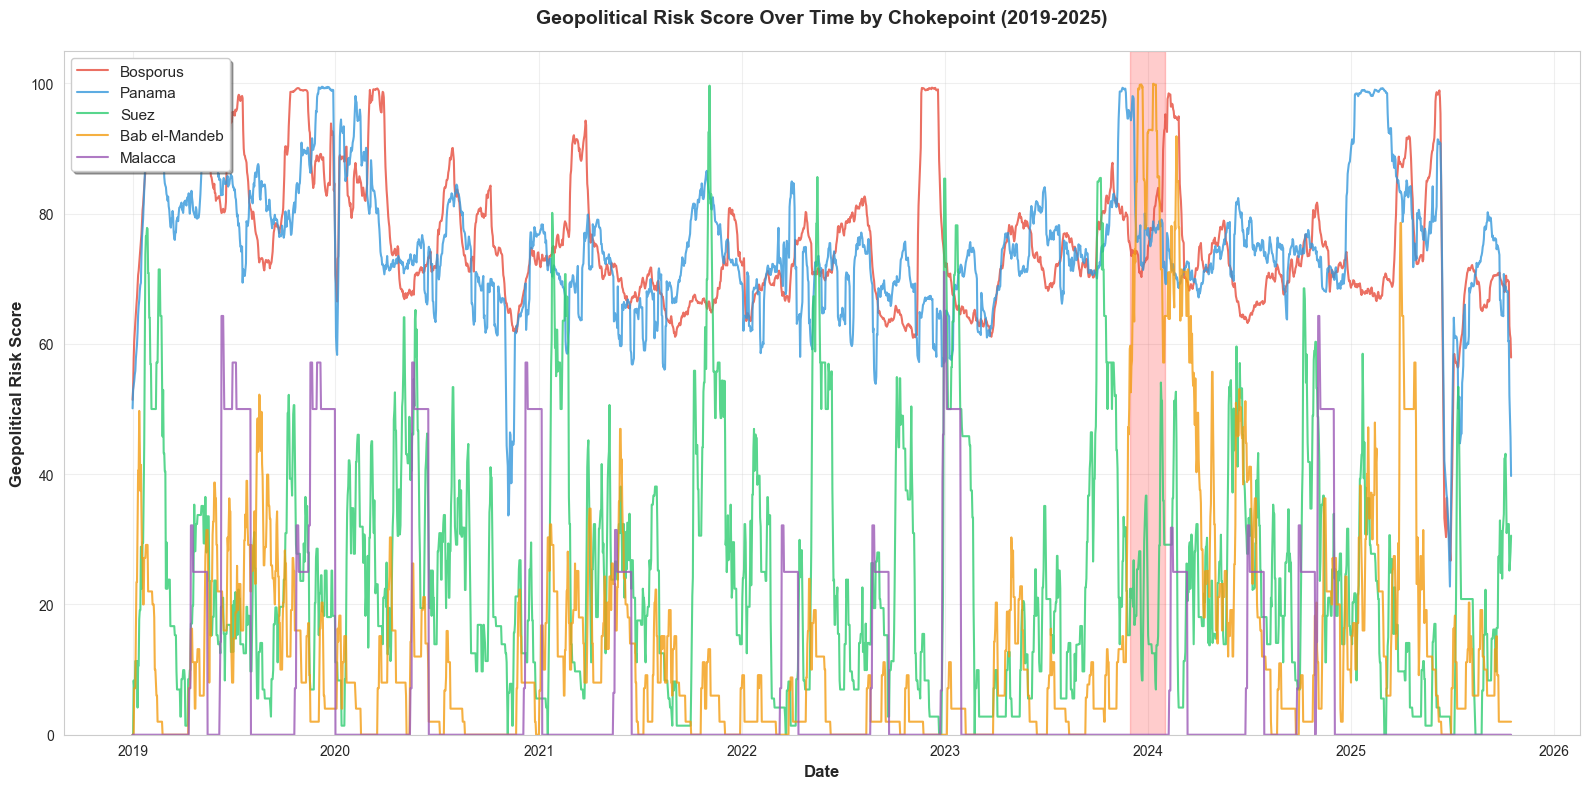

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.dates import DateFormatter, MonthLocator
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

# Load the data
df = pd.read_parquet('gdelt_daily_chokepoints.parquet')
df['date'] = pd.to_datetime(df['date'])

# Color palette for chokepoints
chokepoint_colors = {
    'cp_bosporus': '#e74c3c',      # Red
    'cp_panama': '#3498db',        # Blue
    'cp_suez': '#2ecc71',          # Green
    'cp_bab_el_mandeb': '#f39c12', # Orange
    'cp_malacca': '#9b59b6'        # Purple
}

chokepoint_names = {
    'cp_bosporus': 'Bosporus',
    'cp_panama': 'Panama',
    'cp_suez': 'Suez',
    'cp_bab_el_mandeb': 'Bab el-Mandeb',
    'cp_malacca': 'Malacca'
}

# Time Series - Geopolitical Risk Score Over Time
fig, ax = plt.subplots(figsize=(16, 8))

for cp in chokepoint_colors.keys():
    cp_data = df[df['chokepoint_id'] == cp].sort_values('date')
    ax.plot(cp_data['date'], cp_data['geopolitical_risk_score'], 
            label=chokepoint_names[cp], color=chokepoint_colors[cp], 
            linewidth=1.5, alpha=0.8)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Geopolitical Risk Score', fontsize=12, fontweight='bold')
ax.set_title('Geopolitical Risk Score Over Time by Chokepoint (2019-2025)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)

# Highlight the Red Sea crisis period (Dec 2023 - Jan 2024)
ax.axvspan(pd.Timestamp('2023-12-01'), pd.Timestamp('2024-02-01'), 
           alpha=0.2, color='red', label='Red Sea Crisis')

plt.tight_layout()
plt.savefig('risk_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()



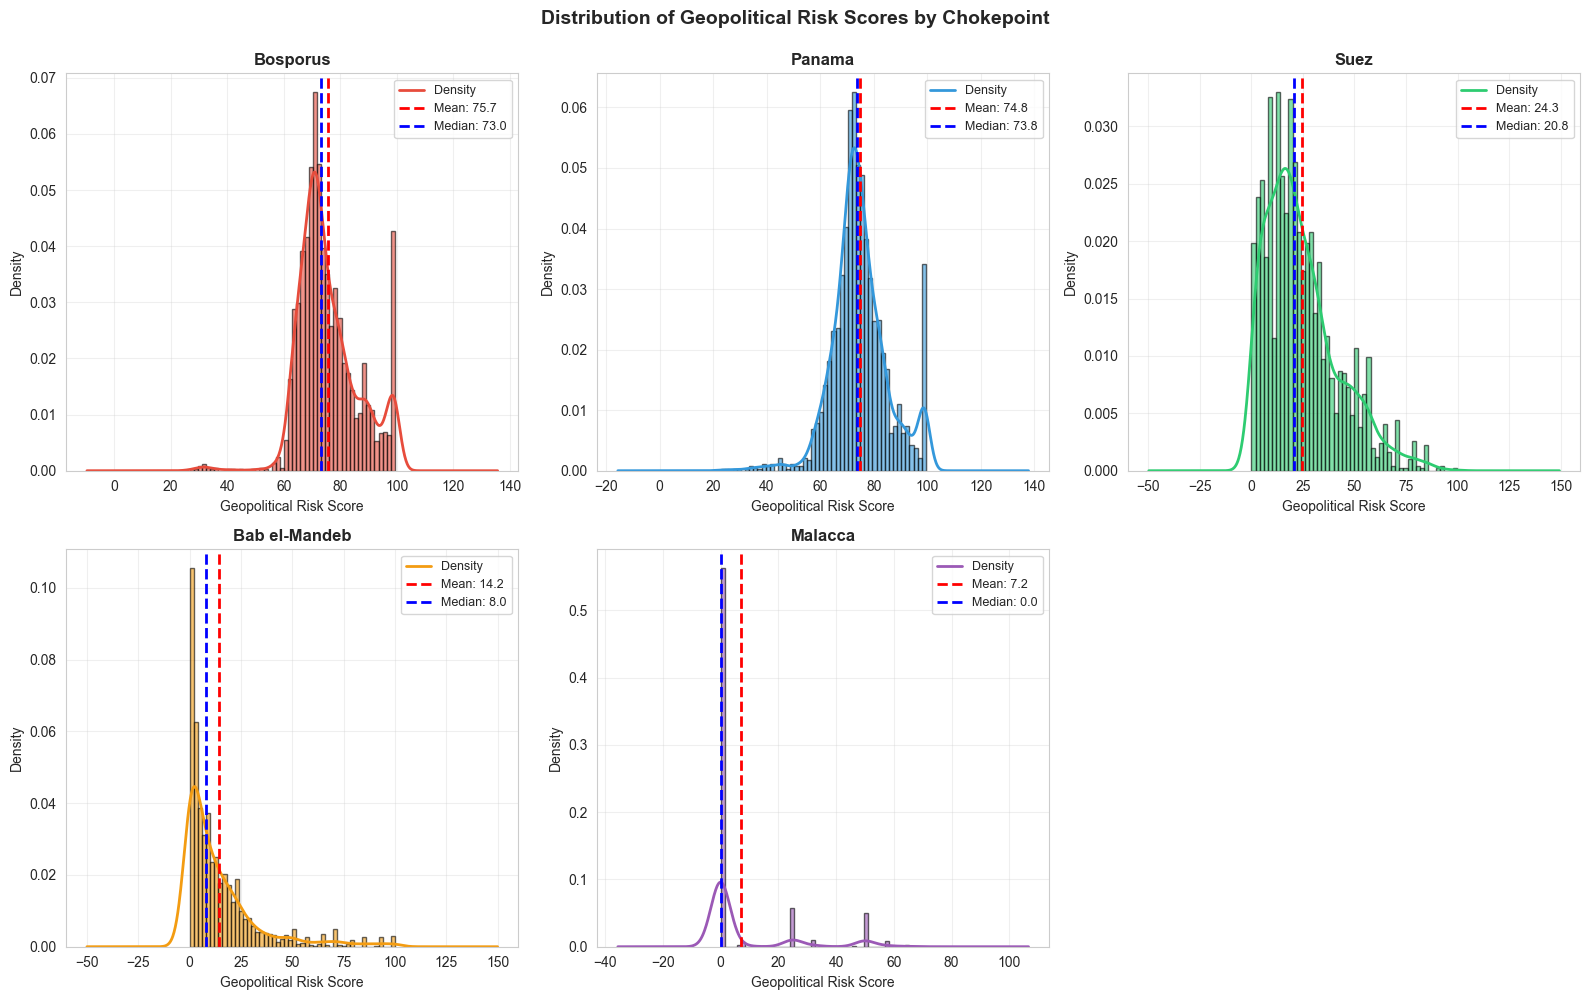

In [ ]:
# Distribution - Risk Score Distribution by Chokepoint
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, cp in enumerate(chokepoint_colors.keys()):
    cp_data = df[df['chokepoint_id'] == cp]['geopolitical_risk_score']
    
    # Histogram with KDE
    axes[idx].hist(cp_data, bins=50, alpha=0.6, color=chokepoint_colors[cp], 
                   edgecolor='black', density=True)
    
    # KDE overlay
    cp_data.plot.kde(ax=axes[idx], color=chokepoint_colors[cp], 
                     linewidth=2, label='Density')
    
    axes[idx].set_title(f'{chokepoint_names[cp]}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Geopolitical Risk Score', fontsize=10)
    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].axvline(cp_data.mean(), color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {cp_data.mean():.1f}')
    axes[idx].axvline(cp_data.median(), color='blue', linestyle='--', 
                      linewidth=2, label=f'Median: {cp_data.median():.1f}')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

# Remove extra subplot
axes[5].axis('off')

plt.suptitle('Distribution of Geopolitical Risk Scores by Chokepoint', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('risk_distribution.png', dpi=300, bbox_inches='tight')
plt.show()



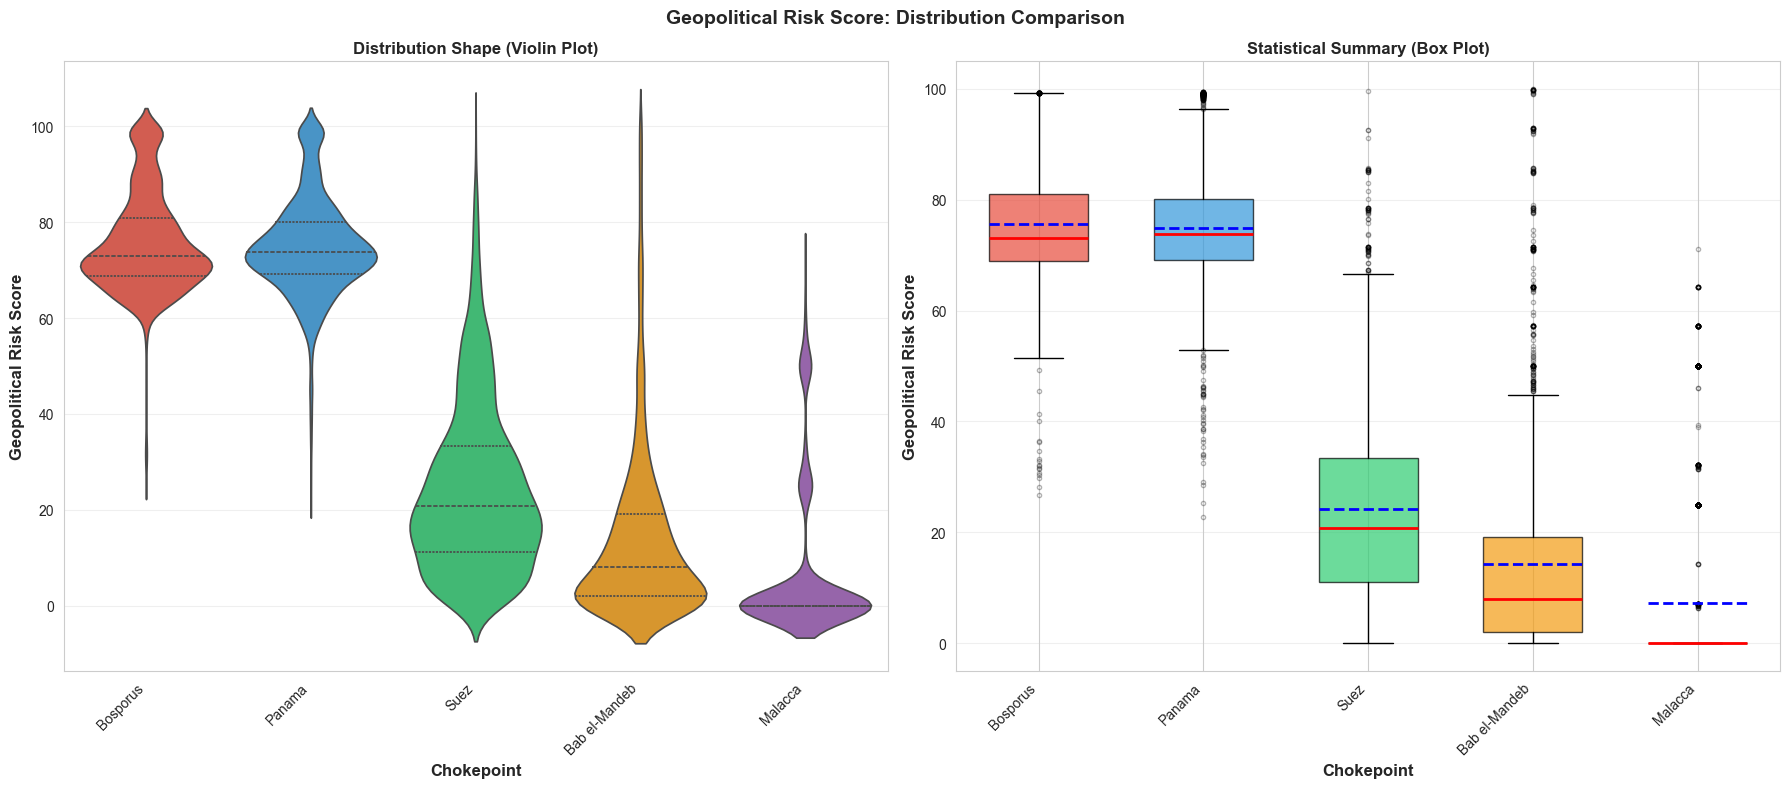

In [ ]:
# Improved Comparison - Violin Plot + Box Plot Combo
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left: Violin plot (shows distribution shape better)
plot_data = df.copy()
plot_data['Chokepoint'] = plot_data['chokepoint_id'].map(chokepoint_names)

sns.violinplot(data=plot_data, x='chokepoint_id', y='geopolitical_risk_score',
               order=chokepoint_colors.keys(), 
               palette=chokepoint_colors, ax=axes[0], inner='quartile')

axes[0].set_xticklabels([chokepoint_names[cp] for cp in chokepoint_colors.keys()], 
                        rotation=45, ha='right')
axes[0].set_ylabel('Geopolitical Risk Score', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Chokepoint', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution Shape (Violin Plot)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Right: Box plot with limited outliers
bp = axes[1].boxplot([df[df['chokepoint_id'] == cp]['geopolitical_risk_score'] 
                      for cp in chokepoint_colors.keys()],
                     labels=[chokepoint_names[cp] for cp in chokepoint_colors.keys()],
                     patch_artist=True, widths=0.6,
                     showmeans=True, meanline=True,
                     boxprops=dict(alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     meanprops=dict(color='blue', linewidth=2, linestyle='--'),
                     flierprops=dict(marker='o', markersize=3, alpha=0.3))  # Smaller outliers

for patch, cp in zip(bp['boxes'], chokepoint_colors.keys()):
    patch.set_facecolor(chokepoint_colors[cp])

axes[1].set_ylabel('Geopolitical Risk Score', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Chokepoint', fontsize=12, fontweight='bold')
axes[1].set_title('Statistical Summary (Box Plot)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticklabels([chokepoint_names[cp] for cp in chokepoint_colors.keys()], 
                        rotation=45, ha='right')

plt.suptitle('Geopolitical Risk Score: Distribution Comparison', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('risk_comparison_improved.png', dpi=300, bbox_inches='tight')
plt.show()

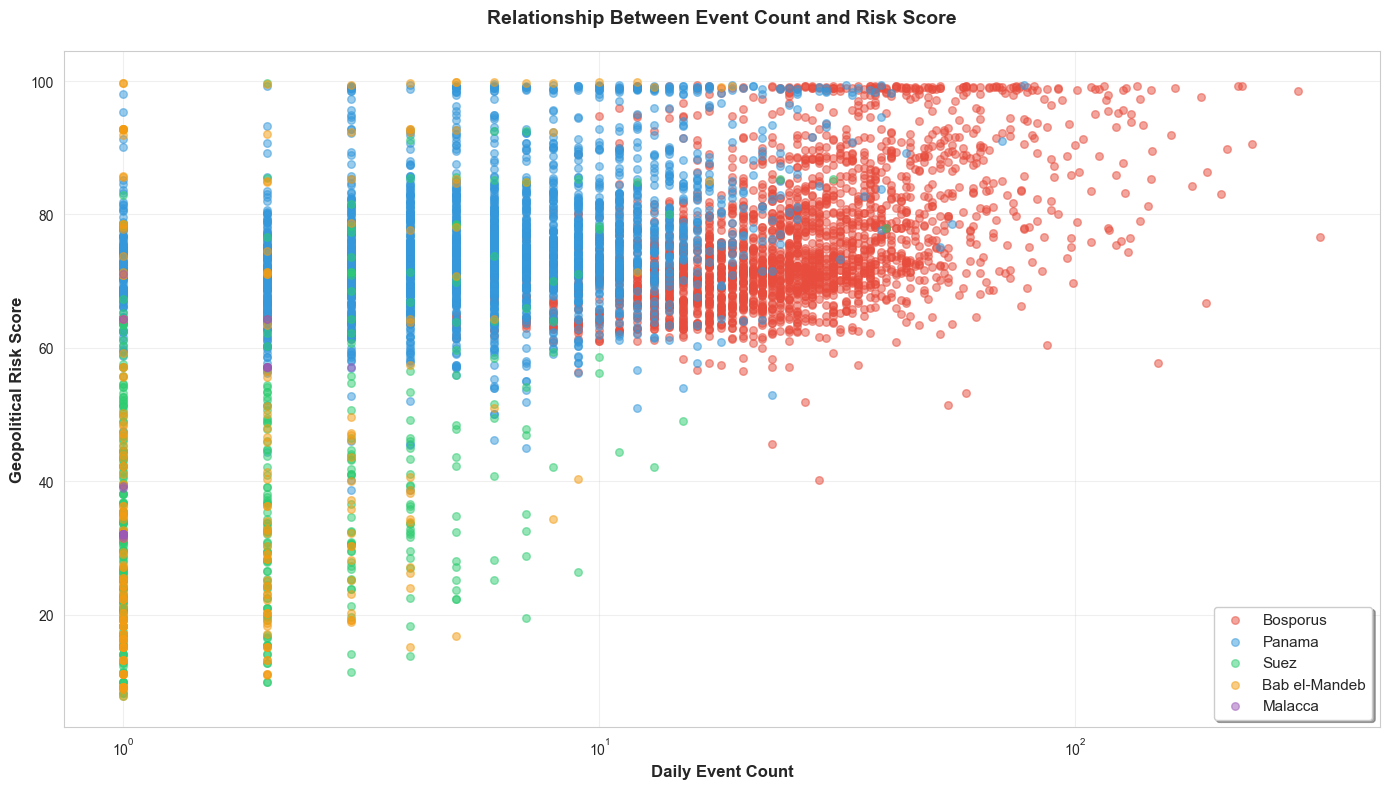

In [ ]:
# Event Frequency vs Risk Score
fig, ax = plt.subplots(figsize=(14, 8))

for cp in chokepoint_colors.keys():
    cp_data = df[df['chokepoint_id'] == cp]
    # Filter out zero events for better visualization
    cp_data_events = cp_data[cp_data['event_count'] > 0]
    
    ax.scatter(cp_data_events['event_count'], 
               cp_data_events['geopolitical_risk_score'],
               alpha=0.5, s=30, color=chokepoint_colors[cp],
               label=chokepoint_names[cp])

ax.set_xlabel('Daily Event Count', fontsize=12, fontweight='bold')
ax.set_ylabel('Geopolitical Risk Score', fontsize=12, fontweight='bold')
ax.set_title('Relationship Between Event Count and Risk Score', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('events_vs_risk.png', dpi=300, bbox_inches='tight')
plt.show()


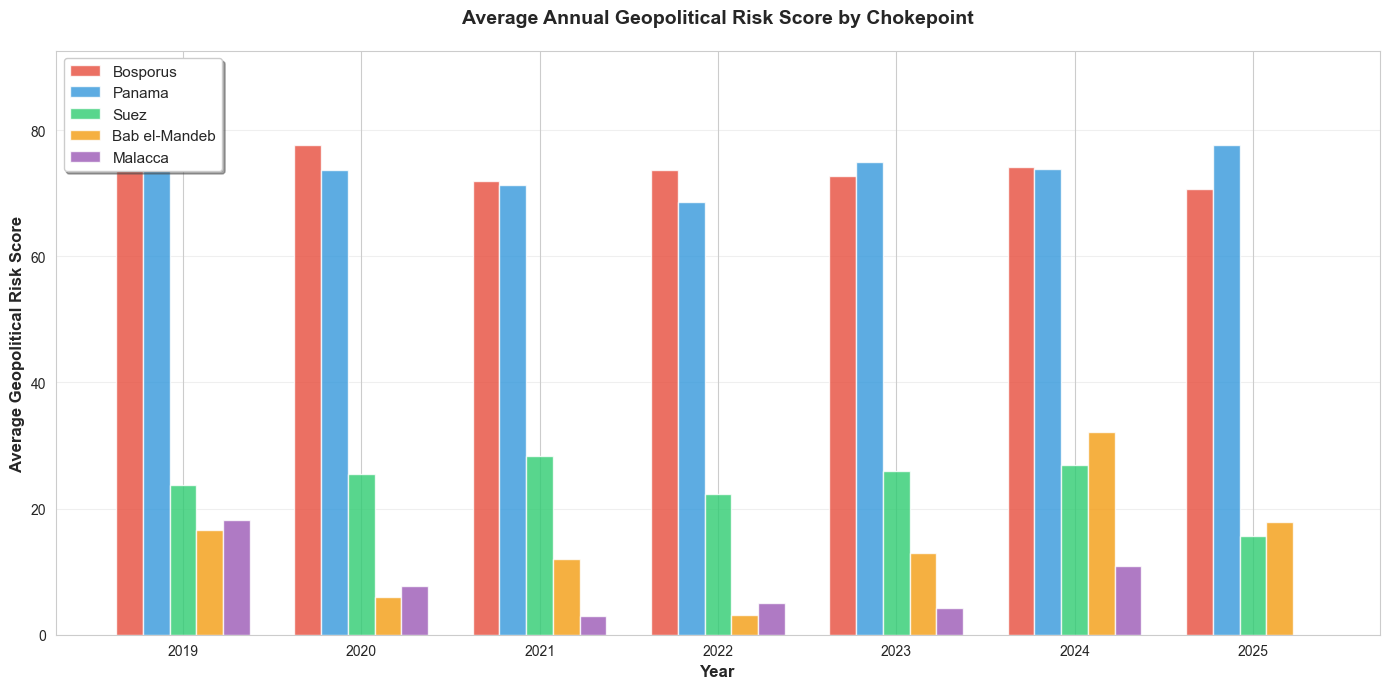

In [ ]:
# Yearly Trends - Average Risk by Year
yearly_risk = df.groupby(['year', 'chokepoint_id'])['geopolitical_risk_score'].mean().reset_index()

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(yearly_risk['year'].unique()))
width = 0.15

for idx, cp in enumerate(chokepoint_colors.keys()):
    cp_yearly = yearly_risk[yearly_risk['chokepoint_id'] == cp]
    offset = width * (idx - 2)
    ax.bar(x + offset, cp_yearly['geopolitical_risk_score'], 
           width, label=chokepoint_names[cp], 
           color=chokepoint_colors[cp], alpha=0.8)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Geopolitical Risk Score', fontsize=12, fontweight='bold')
ax.set_title('Average Annual Geopolitical Risk Score by Chokepoint', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(yearly_risk['year'].unique())
ax.legend(loc='upper left', fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('yearly_trends.png', dpi=300, bbox_inches='tight')
plt.show()

    

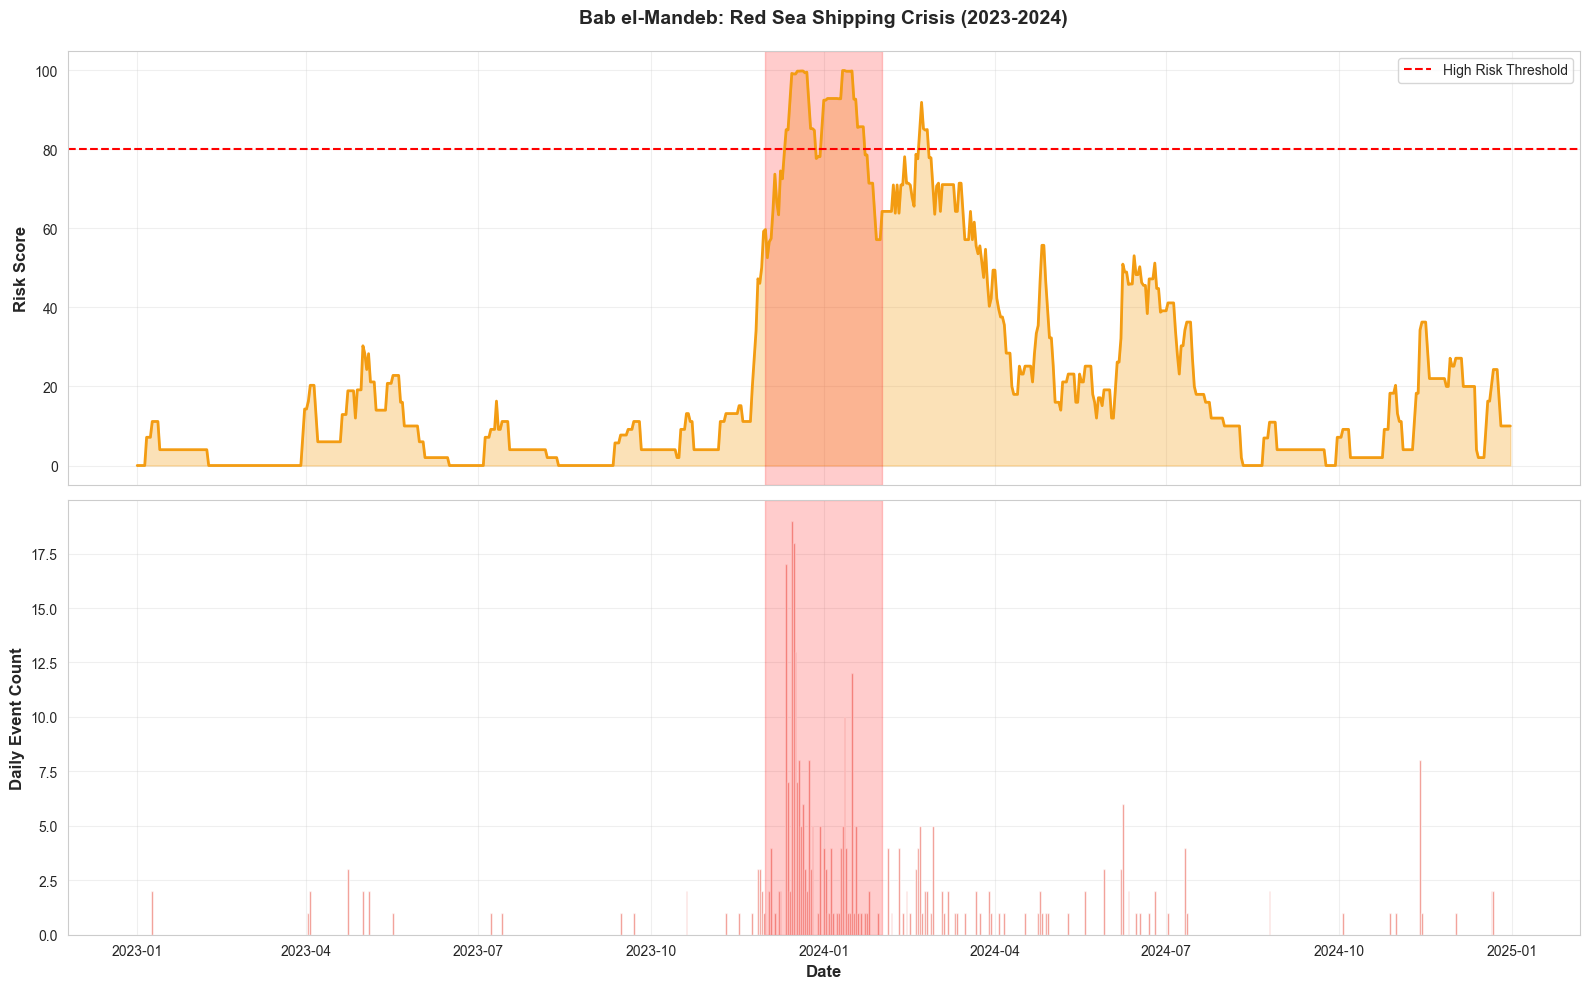

In [ ]:
# Focus on Red Sea Crisis (Bab el-Mandeb)
bab_data = df[df['chokepoint_id'] == 'cp_bab_el_mandeb'].copy()
bab_data = bab_data[(bab_data['date'] >= '2023-01-01') & (bab_data['date'] <= '2024-12-31')]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Risk Score
ax1.plot(bab_data['date'], bab_data['geopolitical_risk_score'], 
         color='#f39c12', linewidth=2)
ax1.fill_between(bab_data['date'], 0, bab_data['geopolitical_risk_score'], 
                 alpha=0.3, color='#f39c12')
ax1.axhline(y=80, color='red', linestyle='--', linewidth=1.5, label='High Risk Threshold')
ax1.set_ylabel('Risk Score', fontsize=12, fontweight='bold')
ax1.set_title('Bab el-Mandeb: Red Sea Shipping Crisis (2023-2024)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Event Count
ax2.bar(bab_data['date'], bab_data['event_count'], 
        color='#e74c3c', alpha=0.7, width=1)
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Daily Event Count', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Highlight crisis period
for ax in [ax1, ax2]:
    ax.axvspan(pd.Timestamp('2023-12-01'), pd.Timestamp('2024-02-01'), 
               alpha=0.2, color='red')

plt.tight_layout()
plt.savefig('red_sea_crisis.png', dpi=300, bbox_inches='tight')
plt.show()